## Oeiras Housing Project

The objective of this project is to analyze real-world housing market data for Oeiras. The process will involve the following steps:

 - **Data Retrieval**: Extract housing data for Oeiras using the Remax API and process the JSON results through data wrangling.
 - **Data Cleaning**: Address null values, standardize data types, and perform additional data wrangling tasks to ensure data quality.
 - **Exploratory Data Analysis (EDA)**: Conduct an in-depth EDA using visualizations to uncover trends and patterns, generating preliminary insights.
 - **Model Development**: Build price prediction models, incorporating preprocessing, feature engineering, and evaluation to deliver accurate predictions.

## 1) Data Collection | Scraping and Data Frame creation from JSON

#### Libraries 

In [217]:
import requests 
import json
from datetime import datetime
import contextlib

import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

##### Scraping using Remax API + Building Data Frame

In [ ]:
# Accessing Remax API. 
# payload  filters houses by Oeiras (602 results as of 09/10)

url = "https://www.remax.pt/api/Listing/PaginatedMultiMatchSearch"
payload = {"filters":[{"field":"businessTypeID","operationType":"int","operator":"=","value":"1","label":"buy"},{"field":"Region2ID","operationType":"string","operator":"=","value":"541"},{"field":"listingClassID","operationType":"int","operator":"=","value":"1"},{"field":"isSpecialExclusive","operator":"=","operationType":"string","value":"false"}],"pageNumber":1,"pageSize":602,"sort":["-ContractDate"],"searchValue":"Oeiras"}

response = requests.post(url, json=payload)

# Parse the JSON response to "data"
data = response.json()

In [ ]:
house_values = ["listingPrice","listingType","marketStatus","conservationStatus","energyEfficiencyLevel",\
                "constructionYear","localZone","garage","garageSpots","floorAsNumber","elevator","totalRooms",\
                    "numberOfBedrooms","numberOfBathrooms","totalArea","livingArea"]

# Creating a list of lists with all houses
house_list =[]
for i in range(len(data["results"])):
    house = []
    for value in house_values:
        house.append(data["results"][i][value])
    house_list.append(house)

# Creating a Pandas Data Frame and storing it in a CSV file
df = pd.DataFrame(house_list, columns=house_values)
df.to_csv('Oeiras Housing2.csv', index=False)

##### Data Dictionary
- listingType, type of building (house, apartment or other)
- marketStatus, new to the market or not
- conservationStatus, state of the listing
- energyEfficiencyLevel, energy efficiency score
- constructionYear, Construction Year
- localZone, Location of the listing
- garage, Has garage or not
- garageSpots, Number of parking spots (garage or not)
- elevator, Elevator or not
- totalRooms, Number of total rooms
- numberOfBedrooms, Number of bedrooms
- numberOfBathrooms, Number of bathrooms
- totalArea, Total area
- livingArea, Actual living area / Usable area
- listingPrice, Listing price

In [203]:
# Sample Data
listing_type = data["results"][0]["listingType"]
market_status = data["results"][0]["marketStatus"]
conservation_status = data["results"][0]["conservationStatus"]
energy_efficiency = data["results"][0]["energyEfficiencyLevel"]
construction_year = data["results"][0]["constructionYear"]
local_zone = data["results"][0]["localZone"]
garage = data["results"][0]["garage"]
garage_spots = data["results"][0]["garageSpots"]
elevator = data["results"][0]["elevator"]
total_rooms = data["results"][0]["totalRooms"]
bedrooms = data["results"][0]["numberOfBedrooms"]
bathrooms = data["results"][0]["numberOfBathrooms"]
total_area = data["results"][0]["totalArea"]
living_area = data["results"][0]["livingArea"]
price = data["results"][0]["listingPrice"]

print(f"Listing Type: {listing_type}")
print(f"Market Status: {market_status}")
print(f"Conservation Status: {conservation_status}")
print(f"Energy Efficiency: {energy_efficiency}")
print(f"Construction Year: {construction_year}")
print(f"Zone: {local_zone}")
print(f"Garage? {garage}")
print(f"Garage Spots: {garage_spots}")
print(f"Elevator? {elevator}")
print(f"Total Rooms: {total_rooms}")
print(f"Bedrooms: {bedrooms}")
print(f"Bathrooms: {bathrooms}")
print(f"Total Area: {total_area}")
print(f"Living Area: {living_area}")
print("")
print(f"Listing Price: {price}")

Listing Type: Apartamento
Market Status: Novo para o Mercado
Conservation Status: None
Energy Efficiency: D
Construction Year: 1997
Zone: Caxias
Garage? False
Garage Spots: 0
Elevator? False
Total Rooms: None
Bedrooms: 3
Bathrooms: 2
Total Area: 110.0
Living Area: 110.0

Listing Price: 260000.0


In [218]:
df = pd.read_csv("Data Studying/Projects/Oeiras Housing.csv")

## 2) Data Inspection & Early EDA | Data Overview

- Overview to identify variable types and distributions
- Perform an initial assessment to determine cleaning needs and potential useful features.

In [219]:
print(df.shape)
df.head()

(593, 16)


,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
0,700000.0,Moradia,Novo para o Mercado,NaN,C,2006.0,Barcarena,False,2,NaN,False,5.0,4.0,3.0,174.0,136.0
1,785000.0,Apartamento,Novo para o Mercado,NaN,B-,2004.0,Algés,False,2,4.0,True,3.0,3.0,3.0,159.0,142.0
2,2595000.0,Moradia,Novo para o Mercado,Como novo,B-,2017.0,Barcarena,True,2,NaN,False,NaN,5.0,6.0,440.0,440.0
3,255000.0,Apartamento,Novo para o Mercado,NaN,C,1979.0,Porto Salvo,False,0,1.0,False,3.0,2.0,1.0,67.0,61.0
4,970000.0,Moradia,Novo para o Mercado,NaN,C,1976.0,Queijas,False,1,NaN,False,4.0,4.0,3.0,203.0,132.0


In [220]:
# Float Values to be cleaned later on.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   listingPrice           593 non-null    float64
 1   listingType            593 non-null    object 
 2   marketStatus           591 non-null    object 
 3   conservationStatus     262 non-null    object 
 4   energyEfficiencyLevel  593 non-null    object 
 5   constructionYear       560 non-null    float64
 6   localZone              593 non-null    object 
 7   garage                 593 non-null    bool   
 8   garageSpots            593 non-null    int64  
 9   floorAsNumber          451 non-null    float64
 10  elevator               516 non-null    object 
 11  totalRooms             371 non-null    float64
 12  numberOfBedrooms       543 non-null    float64
 13  numberOfBathrooms      586 non-null    float64
 14  totalArea              568 non-null    float64
 15  living

In [221]:
df.describe()

,listingPrice,constructionYear,garageSpots,floorAsNumber,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
count,5.930000e+02,560.000000,593.000000,451.000000,371.000000,543.000000,586.000000,568.000000,560.000000
mean,7.242725e+05,1992.635714,1.293423,3.407982,4.353100,3.012891,2.491468,215.961268,138.130357
std,5.672003e+05,148.136992,1.059819,3.152752,2.390716,1.284961,1.462031,861.890608,98.052717
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3.875000e+05,1984.750000,0.000000,1.000000,3.000000,2.000000,2.000000,98.750000,89.750000
50%,6.050000e+05,2008.000000,2.000000,3.000000,4.000000,3.000000,2.000000,136.500000,122.000000
75%,8.300000e+05,2024.000000,2.000000,5.000000,5.000000,4.000000,3.000000,175.000000,153.000000
max,6.500000e+06,2028.000000,3.000000,10.000000,28.000000,11.000000,12.000000,17355.000000,1051.000000


#### Null values

In [222]:
df.isnull().sum()

listingPrice               0
listingType                0
marketStatus               2
conservationStatus       331
energyEfficiencyLevel      0
constructionYear          33
localZone                  0
garage                     0
garageSpots                0
floorAsNumber            142
elevator                  77
totalRooms               222
numberOfBedrooms          50
numberOfBathrooms          7
totalArea                 25
livingArea                33
dtype: int64

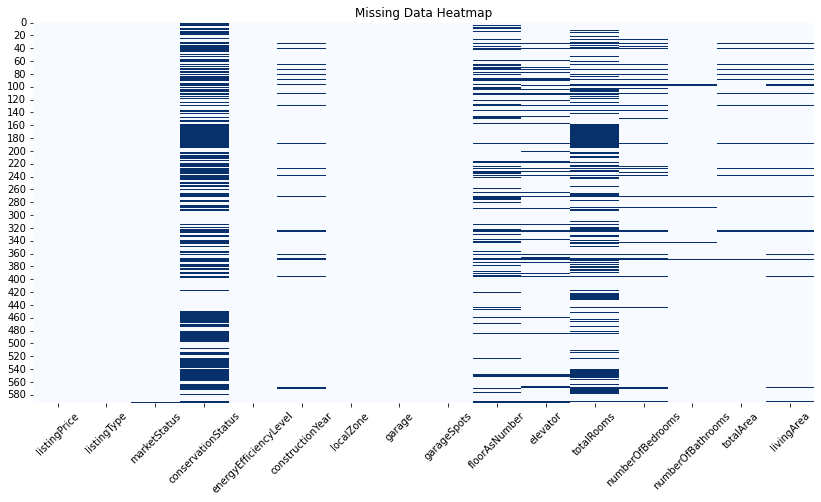

In [223]:
# Heatmap for missing data
plt.figure(figsize=(14, 7))
sns.heatmap(df.isnull(), cmap='Blues', cbar=False)
plt.title('Missing Data Heatmap')
plt.yticks(ticks=range(0, len(df), 20), labels=range(0, len(df), 20), fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.show()

#### Correlation Analysis
- There’s a high correlation between the number of rooms, living area, garage spots, and price, which is expected.
- The msno heatmap highlights correlations between missing values in different columns; higher correlation suggests these columns often have missing values together.
- Notably, a high correlation (0.6) exists between "elevator" and "floorAsNumber," likely because properties with null floor numbers are "Moradias."
- Null values in "construction year" may represent garages or terrains, which typically lack construction dates and may not include fields like "bedrooms" or "total area," which are more relevant to houses.

In [224]:
num_columns = ["listingPrice", "constructionYear","garageSpots","floorAsNumber","elevator","totalRooms","numberOfBedrooms","numberOfBathrooms","totalArea","livingArea"]
df[num_columns].corr()

,listingPrice,constructionYear,garageSpots,floorAsNumber,elevator,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
listingPrice,1.000000,0.033607,0.468820,0.225482,0.070922,0.499174,0.501543,0.536140,0.180291,0.631272
constructionYear,0.033607,1.000000,0.165055,0.111979,0.178026,0.061050,0.047917,0.123715,-0.060226,0.059009
garageSpots,0.468820,0.165055,1.000000,0.324856,0.322699,0.187602,0.323806,0.608070,-0.037823,0.368826
floorAsNumber,0.225482,0.111979,0.324856,1.000000,0.290127,0.054483,0.232928,0.459020,0.029134,0.261884
elevator,0.070922,0.178026,0.322699,0.290127,1.000000,-0.092362,-0.000025,0.204019,-0.068807,-0.017270
totalRooms,0.499174,0.061050,0.187602,0.054483,-0.092362,1.000000,0.872606,0.673674,0.410061,0.738774
numberOfBedrooms,0.501543,0.047917,0.323806,0.232928,-0.000025,0.872606,1.000000,0.653313,0.348825,0.692678
numberOfBathrooms,0.536140,0.123715,0.608070,0.459020,0.204019,0.673674,0.653313,1.000000,-0.060643,0.457973
totalArea,0.180291,-0.060226,-0.037823,0.029134,-0.068807,0.410061,0.348825,-0.060643,1.000000,0.607936
livingArea,0.631272,0.059009,0.368826,0.261884,-0.017270,0.738774,0.692678,0.457973,0.607936,1.000000


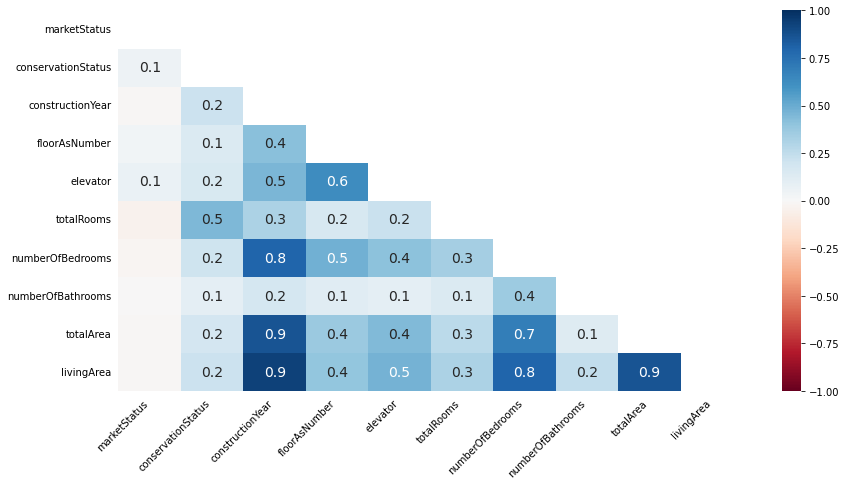

In [225]:
msno.heatmap(df, figsize=(14, 7))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Duplicates

In [226]:
print(f"There are: {df.duplicated().sum()} duplicate rows")

There are: 17 duplicate rows


### Numeric Data

##### Histograms - Representation of the distribution for each single feature. 
- We observe skewness in values like price, area, and rooms, as most houses are "average," with a few more luxurious ones.
- This skewness will need to be addressed during modeling.

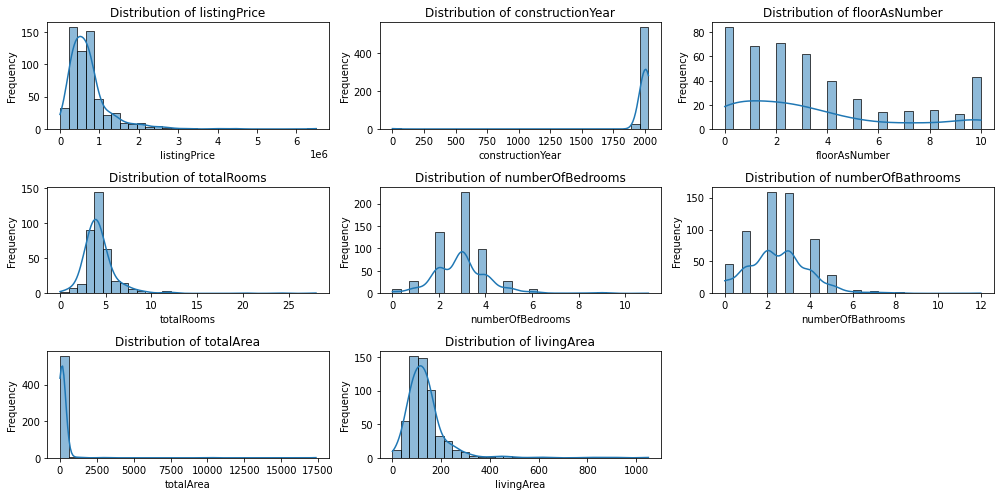

In [227]:
plt.figure(figsize=(14,7))
for i, column in enumerate(df.select_dtypes(include='float64').columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

##### Skewness Check
- A skewness close to 0 indicates a normal distribution
- Values greater than 0 indicate right skewness
- Right skewness makes sense, for example, for listing price, which follows a normal distribution while there are a few expensive houses (right skewness)

In [228]:
skewness = df.select_dtypes(include='float64').skew()
print('Skewness of numerical features:\n', skewness)

Skewness of numerical features:
 listingPrice          3.627962
constructionYear    -13.105431
floorAsNumber         0.891965
totalRooms            5.248589
numberOfBedrooms      1.410845
numberOfBathrooms     0.820409
totalArea            16.860233
livingArea            4.481552
dtype: float64


##### Boxplots to identify potential outliers
- One construction year = 0
- A house with nearly 30 rooms
- A house with nearly 15 rooms is suspicious
- A house with an area of 17500 squared meters

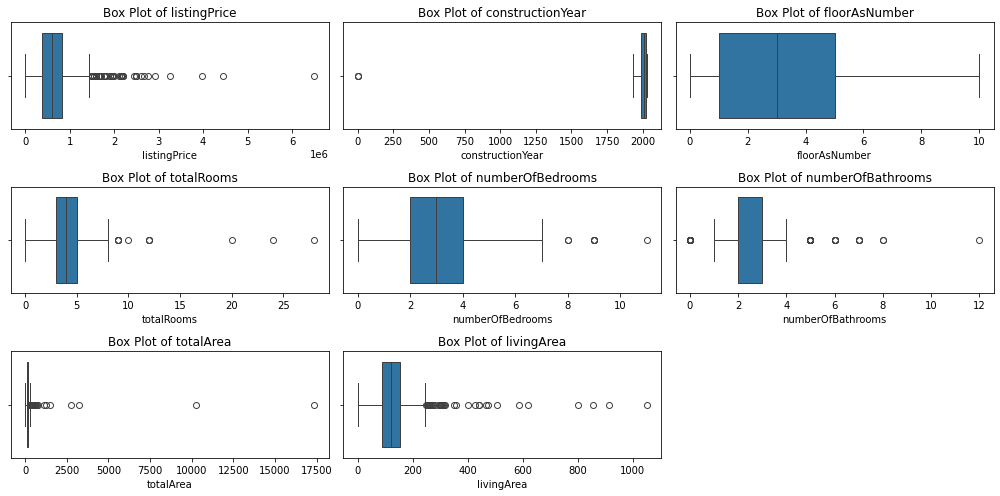

In [229]:
plt.figure(figsize=(14, 7))
for i, column in enumerate(df.select_dtypes(include='float64').columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

#### Q-Q Plots
- Compare the quantiles against a normal distribution to assess normality
- If data points follow a straight line in the Q-Q plot, the distribution can be considered normal


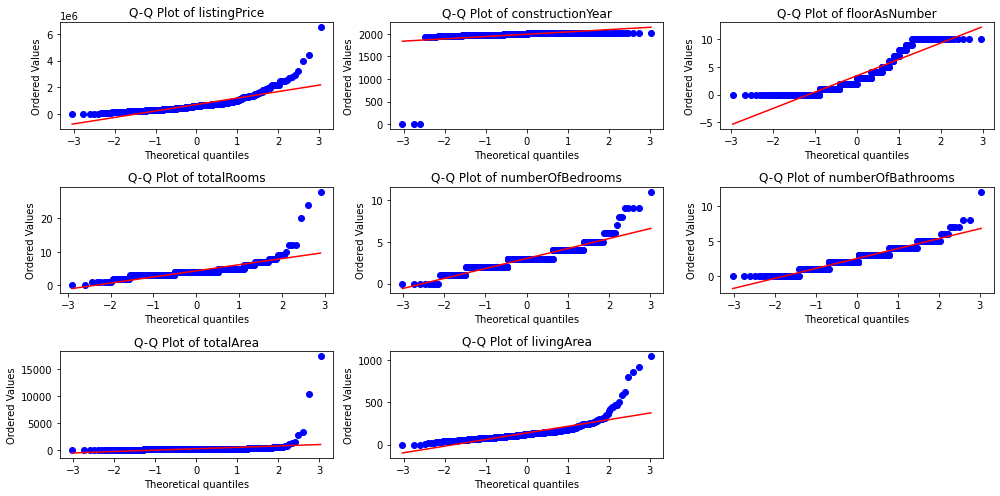

In [230]:
plt.figure(figsize=(14, 7))
for i, column in enumerate(df.select_dtypes(include='float64').columns, 1):
    plt.subplot(3, 3, i)
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
plt.tight_layout()
plt.show()

#### Categorical Variables
- We also ensure data integrity for categorical values by checking for typos or unusual entries.
- For instance, there appears to be a region labeled "187."

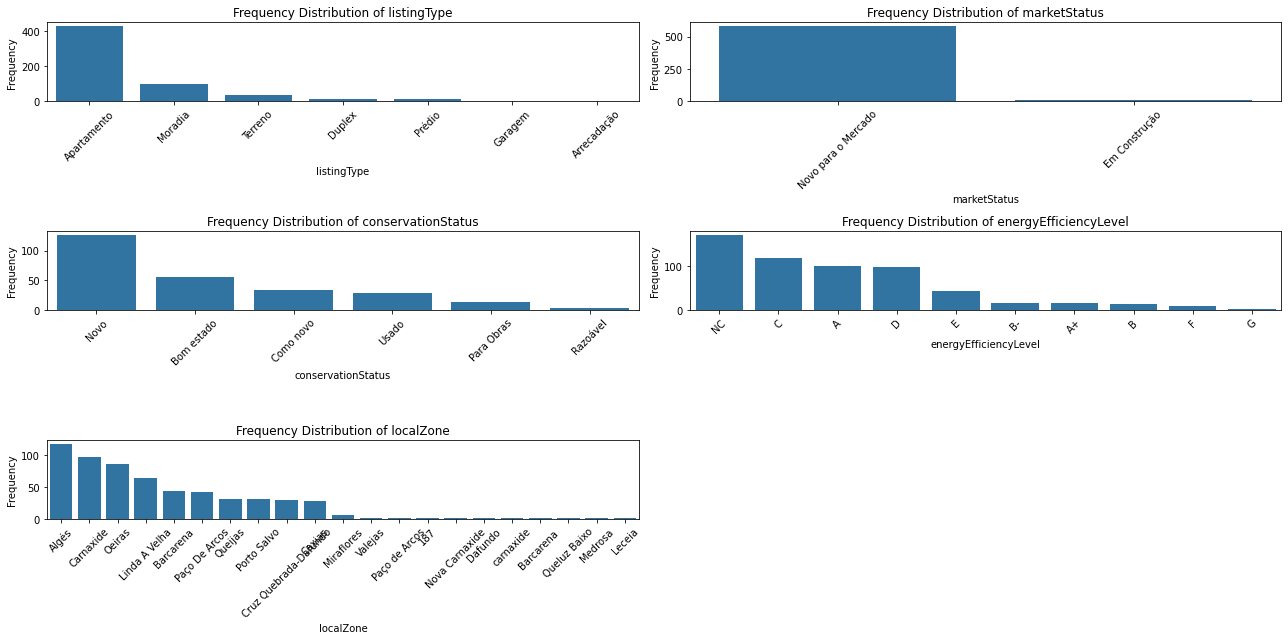

In [231]:
categorical_vars = ['listingType', 'marketStatus', 'conservationStatus', 'energyEfficiencyLevel','localZone']

plt.figure(figsize=(18, 9))

# Number of rows and columns needed for the subplots
num_vars = len(categorical_vars)
cols = 2 
rows = np.ceil(num_vars / cols).astype(int)

# Loop through each categorical variable and create a bar plot
for i, variable in enumerate(categorical_vars, 1):
    plt.subplot(rows, cols, i)
    sns.barplot(x=df[variable].value_counts().index, 
                y=df[variable].value_counts().values)
    plt.title(f'Frequency Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

#### Scatter Plot

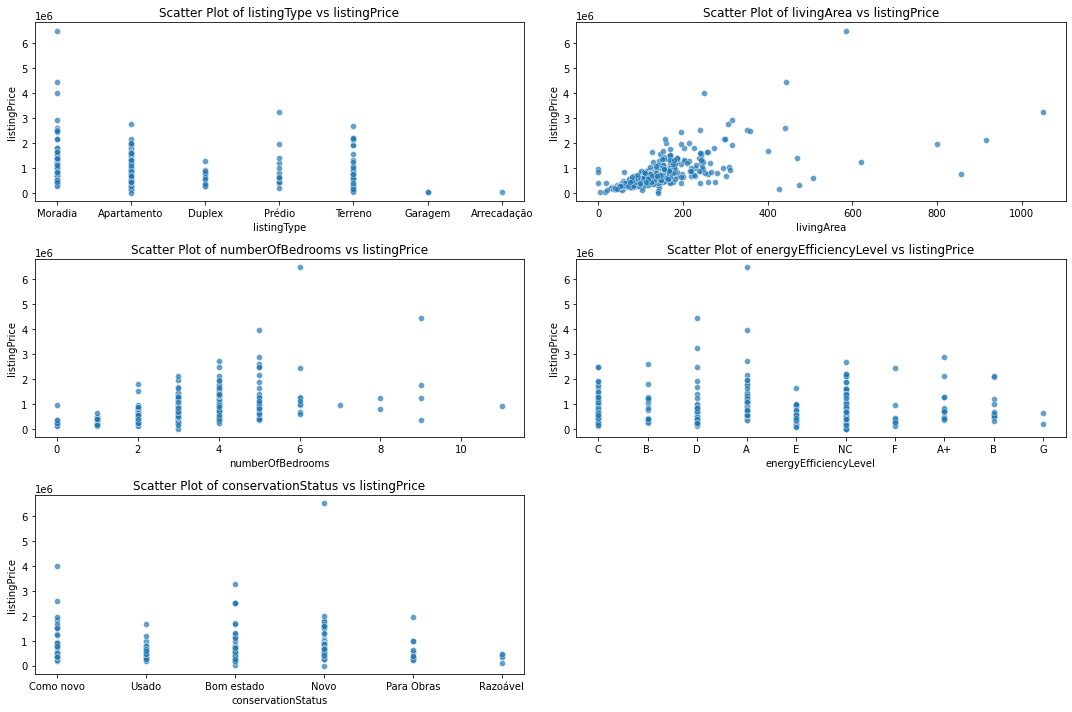

In [232]:
feature_vars = ['listingType', 'livingArea','numberOfBedrooms','energyEfficiencyLevel', 'conservationStatus']
target_variable = 'listingPrice'

plt.figure(figsize=(15, 10))

num_vars = len(feature_vars)
cols = 2
rows = np.ceil(num_vars / cols).astype(int)

# Loop through each variable and create a scatter plot
for i, feature_variable in enumerate(feature_vars, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(x=df[feature_variable], y=df[target_variable], alpha=0.7)
    plt.title(f'Scatter Plot of {feature_variable} vs {target_variable}')
    plt.xlabel(feature_variable)
    plt.ylabel(target_variable)
plt.tight_layout()
plt.show()

## 3) Data Cleaning

#### 3.1) Handling Missing Values

##### Listing Type
- To focus on houses and apartments, we need to exclude unwanted structures like garages, entire buildings, and terrains.
- This step should also help reduce the number of null values in the data

listingType
Apartamento    427
Moradia         97
Terreno         39
Duplex          14
Prédio          13
Garagem          2
Arrecadação      1
Name: count, dtype: int64


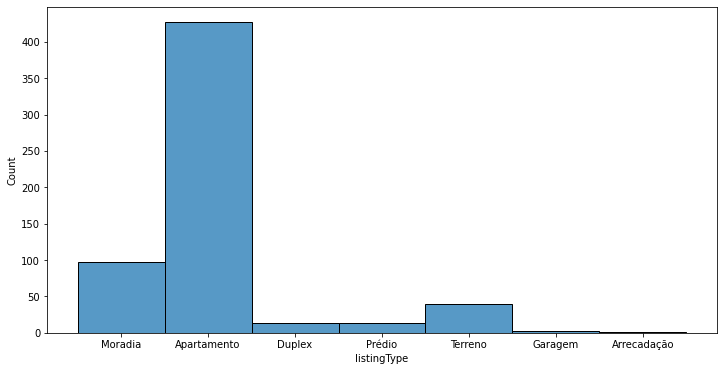

In [233]:
print(df["listingType"].value_counts())
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="listingType")
plt.show()

In [234]:
df = df.loc[~df["listingType"].isin(["Terreno", "Prédio", "Garagem", "Arrecadação"])]

##### Market Status
- Since the unique values for "MarketStatus" are 'New in the Market' or 'In Construction,' and most houses appear not to be under construction (as shown in the histplot), we’ll treat blank entries as 'New in the Market.'

In [235]:
print(df["marketStatus"].unique())
df[df["marketStatus"].isnull()]

['Novo para o Mercado' 'Em Construção' nan]


,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
480,300000.0,Apartamento,NaN,NaN,D,1991.0,Porto Salvo,False,0,2.0,False,4.0,3.0,2.0,83.0,83.0
592,845000.0,Moradia,NaN,NaN,D,1985.0,Leceia,False,0,NaN,NaN,5.0,3.0,4.0,267.0,267.0


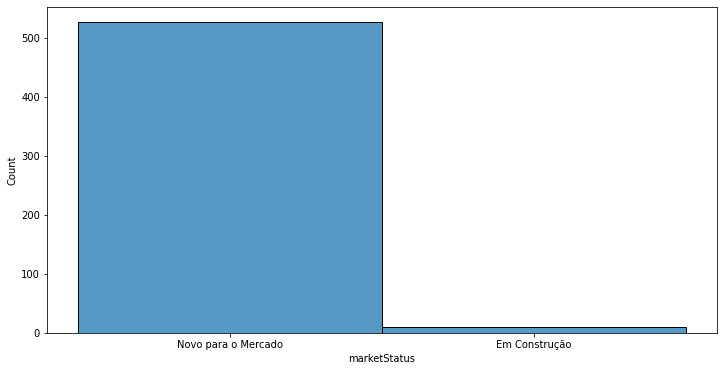

In [236]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="marketStatus")
plt.show()

In [237]:
df["marketStatus"] = df["marketStatus"].fillna("Novo para o Mercado")

##### Construction Year
- There are two outlier entries for construction year, which will be replaced with the mean value.

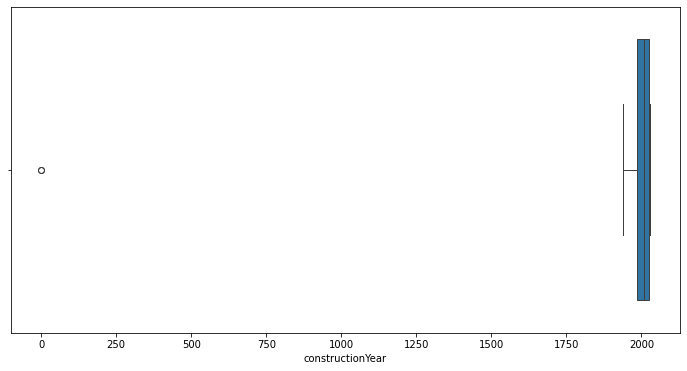

In [238]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="constructionYear")
plt.show()

In [239]:
df.loc[df["constructionYear"] == 0]

,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
109,169000.0,Apartamento,Novo para o Mercado,Como novo,E,0.0,Algés,False,0,0.0,False,2.0,1.0,1.0,45.0,40.0
142,990000.0,Moradia,Novo para o Mercado,Para Obras,F,0.0,Algés,True,1,NaN,False,5.0,5.0,3.0,175.0,157.0


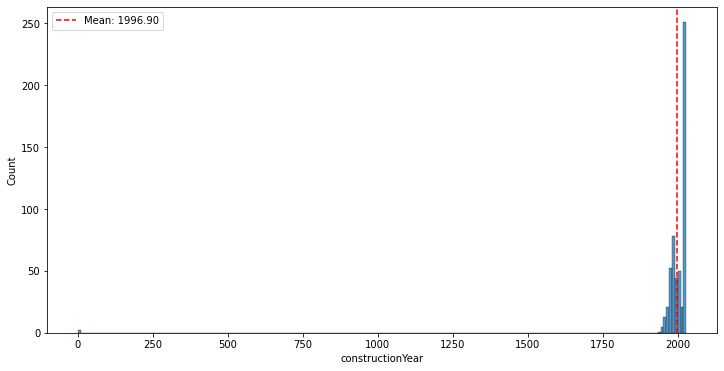

In [240]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="constructionYear")

mean_construction_year = df['constructionYear'].mean()
plt.axvline(mean_construction_year, color='red', linestyle='--', label=f'Mean: {mean_construction_year:.2f}')

plt.legend()
plt.show()

In [241]:
mean_construction_year = df["constructionYear"].mean()
df["constructionYear"] = df["constructionYear"].replace(0, mean_construction_year)

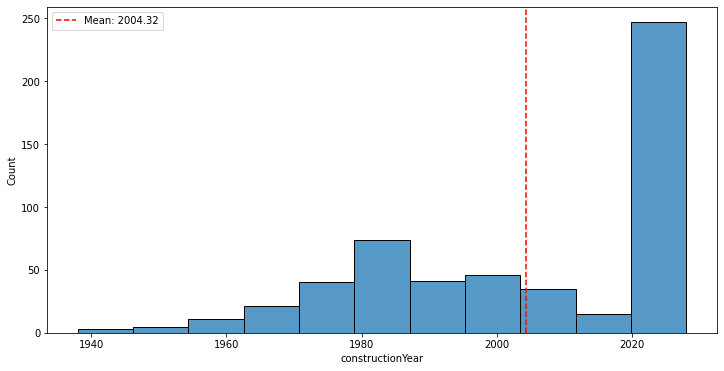

In [242]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="constructionYear")

mean_construction_year = df['constructionYear'].mean()
plt.axvline(mean_construction_year, color='red', linestyle='--', label=f'Mean: {mean_construction_year:.2f}')

plt.legend()
plt.show()

##### Conservation Status
- Given the wide range of possible values for Conservation Status, the most effective approach is to predict it based on price and house age.

In [243]:
print(df["conservationStatus"].unique())
df[df["conservationStatus"].isnull()].head().sort_values(by="constructionYear", ascending=False)

[nan 'Como novo' 'Usado' 'Bom estado' 'Novo' 'Para Obras' 'Razoável']


,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
0,700000.0,Moradia,Novo para o Mercado,NaN,C,2006.0,Barcarena,False,2,NaN,False,5.0,4.0,3.0,174.0,136.0
1,785000.0,Apartamento,Novo para o Mercado,NaN,B-,2004.0,Algés,False,2,4.0,True,3.0,3.0,3.0,159.0,142.0
3,255000.0,Apartamento,Novo para o Mercado,NaN,C,1979.0,Porto Salvo,False,0,1.0,False,3.0,2.0,1.0,67.0,61.0
4,970000.0,Moradia,Novo para o Mercado,NaN,C,1976.0,Queijas,False,1,NaN,False,4.0,4.0,3.0,203.0,132.0
9,990000.0,Moradia,Novo para o Mercado,NaN,E,1951.0,Cruz Quebrada-Dafundo,False,0,NaN,False,3.0,2.0,2.0,166.0,229.0


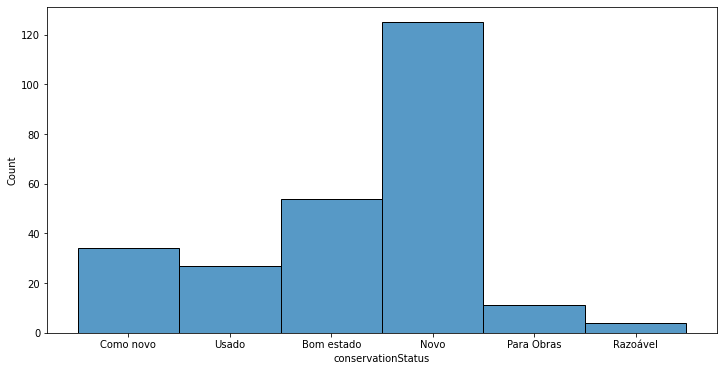

In [244]:
plt.figure(figsize=(12,6))
sns.histplot(data=df, x="conservationStatus")
plt.show()

In [245]:
df_backup = df.copy()

In [246]:
# Quick Feature Engineering for house "age"
current_year = datetime.now().year
df["Age"] = current_year - df["constructionYear"]

# Using Random Forest Classifier:
df_notnull = df[df["conservationStatus"].notnull()]
df_null = df[df["conservationStatus"].isnull()]

X = df_notnull[["Age", "listingPrice"]]
y = df_notnull["conservationStatus"]

# Train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions and Accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Predict missing values
df_null["conservationStatus"] = model.predict(df_null[["Age", "listingPrice"]])
df = pd.concat([df_notnull, df_null])


Accuracy: 0.69


/tmp/ipykernel_616/95620526.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null["conservationStatus"] = model.predict(df_null[["Age", "listingPrice"]])


##### Floor
- It is expected for R/C to be set to 0 and for "Moradias" to have null values. In both cases, these should be updated to 0.

In [247]:
floor_nulls = df.loc[df["floorAsNumber"].isnull()]
floor_nulls.head()

,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,totalRooms,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,Age
2,2595000.0,Moradia,Novo para o Mercado,Como novo,B-,2017.0,Barcarena,True,2,NaN,False,NaN,5.0,6.0,440.0,440.0,7.0
7,690000.0,Moradia,Novo para o Mercado,Bom estado,D,2011.0,Barcarena,False,1,NaN,False,10.0,6.0,4.0,302.0,302.0,13.0
36,1050000.0,Moradia,Novo para o Mercado,Novo,B-,1996.0,Barcarena,True,2,NaN,False,7.0,4.0,6.0,274.0,308.0,28.0
53,6500000.0,Moradia,Novo para o Mercado,Novo,A,2023.0,Cruz Quebrada-Dafundo,True,3,NaN,True,9.0,6.0,8.0,586.0,586.0,1.0
66,835000.0,Moradia,Novo para o Mercado,Bom estado,B-,2010.0,Barcarena,True,2,NaN,False,7.0,5.0,4.0,167.0,140.0,14.0


In [248]:
floor_nulls["listingType"].unique()

array(['Moradia'], dtype=object)

In [249]:
df["floorAsNumber"] = df["floorAsNumber"].fillna(0)

##### Elevator
- "Moradias" are very unlikely to have an elevator. Setting null values to FALSE

In [250]:
elevator_nulls = df.loc[df["elevator"].isnull()]
print(df["elevator"].unique())
print(elevator_nulls["listingType"].unique())

df["elevator"] = df["elevator"].fillna(False)

[False True nan]
['Moradia']


##### Total Rooms
- The "Total rooms" value appears to include other areas like garages, but this is unclear when cross-referenced with the website information.
- Given this uncertainty and the availability of more accurate data for bathrooms and bedrooms, I will drop this column.

In [251]:
df = df.drop(columns=["totalRooms"])

In [252]:
df.isnull().sum()

listingPrice             0
listingType              0
marketStatus             0
conservationStatus       0
energyEfficiencyLevel    0
constructionYear         0
localZone                0
garage                   0
garageSpots              0
floorAsNumber            0
elevator                 0
numberOfBedrooms         0
numberOfBathrooms        0
totalArea                0
livingArea               0
Age                      0
dtype: int64

#### 3.2) Duplicate Values, Data Types and Data Quality Checks

##### Duplicate Values

In [253]:
duplicates = df.duplicated()
duplicate_values = len(df[duplicates])
print(f"There are: {duplicate_values} duplicate rows")

There are: 17 duplicate rows


In [254]:
df = df.drop_duplicates()

##### Data Types
- Updating float values to int

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 2 to 592
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   listingPrice           521 non-null    float64
 1   listingType            521 non-null    object 
 2   marketStatus           521 non-null    object 
 3   conservationStatus     521 non-null    object 
 4   energyEfficiencyLevel  521 non-null    object 
 5   constructionYear       521 non-null    float64
 6   localZone              521 non-null    object 
 7   garage                 521 non-null    bool   
 8   garageSpots            521 non-null    int64  
 9   floorAsNumber          521 non-null    float64
 10  elevator               521 non-null    bool   
 11  numberOfBedrooms       521 non-null    float64
 12  numberOfBathrooms      521 non-null    float64
 13  totalArea              521 non-null    float64
 14  livingArea             521 non-null    float64
 15  Age        

In [256]:
columns_to_convert = ["listingPrice","constructionYear","floorAsNumber","numberOfBedrooms","numberOfBathrooms","totalArea","livingArea","Age"]

df[columns_to_convert] = df[columns_to_convert].astype(int)

#### Checking for Invalid Data and Ensuring Data Consistency
- There is a house listed for -1 euro.
- Construction years seem to make sense. More recent years relate to houses under construction
- Garage Spots, Floor Number and Number of Bedrooms seem accurate
- Number of Bathrooms = 0 seem suspicious
- Area values seem suspicious

In [257]:
df.describe()

,listingPrice,constructionYear,garageSpots,floorAsNumber,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,Age
count,5.210000e+02,521.000000,521.00000,521.000000,521.000000,521.000000,521.000000,521.000000,521.000000
mean,7.102469e+05,2003.669866,1.37428,2.798464,3.019194,2.639155,150.232246,129.568138,20.326296
std,5.461124e+05,22.125743,1.03405,3.117518,1.294818,1.284644,155.618523,67.435237,22.124496
min,-1.000000e+00,1938.000000,0.00000,0.000000,0.000000,0.000000,3.000000,0.000000,-4.000000
25%,3.900000e+05,1985.000000,0.00000,0.000000,2.000000,2.000000,96.000000,89.000000,0.000000
50%,5.950000e+05,2008.000000,2.00000,2.000000,3.000000,3.000000,134.000000,120.000000,16.000000
75%,8.050000e+05,2024.000000,2.00000,4.000000,4.000000,3.000000,165.000000,152.000000,39.000000
max,6.500000e+06,2028.000000,3.00000,10.000000,11.000000,8.000000,3233.000000,620.000000,86.000000


In [258]:
df.loc[df["listingPrice"]== -1]

,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,Age
573,-1,Apartamento,Novo para o Mercado,Novo,NC,2021,Barcarena,False,2,3,True,3,2,202,140,3


In [259]:
# Dropping this house with price -1, probably an error on the website listing

index_to_drop = df.loc[df["listingPrice"]== -1].index
df = df.drop(index=index_to_drop)

In [260]:
# Probably errors on the listing again. These houses have no reason to have 0 bathrooms.
# Removing these 4 entries from the df

index_to_drop_bathrooms = df.loc[df["numberOfBathrooms"]==0].index
index_to_drop_bathrooms

df = df.drop(index=index_to_drop_bathrooms)

In [261]:
# Max and Min area values are suspicious. After checking, these entries are definitely invalid.

df.loc[df["totalArea"] == 3233]

,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,Age
345,650000,Apartamento,Novo para o Mercado,Bom estado,D,2009,Queijas,True,2,3,True,4,2,3233,170,15


In [262]:
df.loc[df["totalArea"] == 3]

,listingPrice,listingType,marketStatus,conservationStatus,energyEfficiencyLevel,constructionYear,localZone,garage,garageSpots,floorAsNumber,elevator,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,Age
41,405000,Apartamento,Novo para o Mercado,Bom estado,C,1985,Oeiras,False,0,3,True,3,2,3,19,39


In [263]:
# Removing both invalid entries.

to_remove1 = df.loc[df["totalArea"] == 3233].index
to_remove2 = df.loc[df["totalArea"] == 3].index

df = df.drop(index=to_remove1)
df = df.drop(index=to_remove2)

In [264]:
# For houses with no living area, we can safely set it equal to the total area. This approach would differ for "Moradias."

df.loc[df["livingArea"] == 0, "livingArea"] = df["totalArea"]

In [265]:
# Quick Sanity check
df.iloc[144]

listingPrice                          742400
listingType                      Apartamento
marketStatus             Novo para o Mercado
conservationStatus                Bom estado
energyEfficiencyLevel                      C
constructionYear                        2013
localZone                      Linda A Velha
garage                                  True
garageSpots                                2
floorAsNumber                              2
elevator                                True
numberOfBedrooms                           3
numberOfBathrooms                          2
totalArea                                159
livingArea                               159
Age                                       11
Name: 375, dtype: object

In [266]:
df.describe()

,listingPrice,constructionYear,garageSpots,floorAsNumber,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,Age
count,5.140000e+02,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,7.153301e+05,2003.805447,1.383268,2.809339,3.021401,2.663424,144.764591,130.342412,20.190661
std,5.476282e+05,22.169406,1.033075,3.129846,1.299846,1.271039,76.922336,67.088108,22.168120
min,1.200000e+05,1938.000000,0.000000,0.000000,0.000000,1.000000,25.000000,20.000000,-4.000000
25%,3.912500e+05,1985.000000,0.000000,0.000000,2.000000,2.000000,96.250000,89.000000,0.000000
50%,5.993800e+05,2008.000000,2.000000,2.000000,3.000000,3.000000,134.000000,120.000000,16.000000
75%,8.050350e+05,2024.000000,2.000000,4.000000,4.000000,3.000000,165.000000,152.000000,39.000000
max,6.500000e+06,2028.000000,3.000000,10.000000,11.000000,8.000000,620.000000,620.000000,86.000000


## 4) Post-Cleaning EDA | Verify Cleaning and Preliminary Conclusions

In [267]:
df_eda = df.copy()
df_eda.columns

Index(['listingPrice', 'listingType', 'marketStatus', 'conservationStatus',
       'energyEfficiencyLevel', 'constructionYear', 'localZone', 'garage',
       'garageSpots', 'floorAsNumber', 'elevator', 'numberOfBedrooms',
       'numberOfBathrooms', 'totalArea', 'livingArea', 'Age'],
      dtype='object')

#### 4.1) Univariate Analysis

##### Listing Type

 - As expected, the most frequent value is "apartments" (79.2%).

listingType
Apartamento    407
Moradia         93
Duplex          14
Name: count, dtype: int64


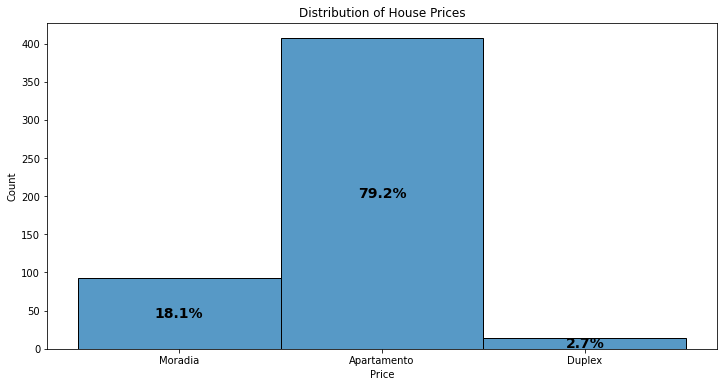

In [268]:
print(df_eda['listingType'].value_counts())

data = df_eda['listingType']

plt.figure(figsize=(12,6))
ax = sns.histplot(data, bins=30, kde=False, stat='count')

total = len(data)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = height / total * 100

        ax.text(p.get_x() + p.get_width() / 2,
                p.get_height() / 2,
                f'{percentage:.1f}%',       
                ha='center', va='center',     
                color='black', fontsize=14,
                fontweight='bold')

plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

##### Conservation Status

 - Surprisingly, most properties are labeled as "New."
 - The data is ambiguous, as it's unclear what differentiates a house that is "Razoável" from one that is "Usada".
 - "Como novo" is also difficult to distinguish from "Bom estado."
 - Given the high ambiguity, it may be best to remove this variable from our model later.

conservationStatus
Novo          222
Bom estado    147
Como novo      67
Usado          54
Para Obras     20
Razoável        4
Name: count, dtype: int64


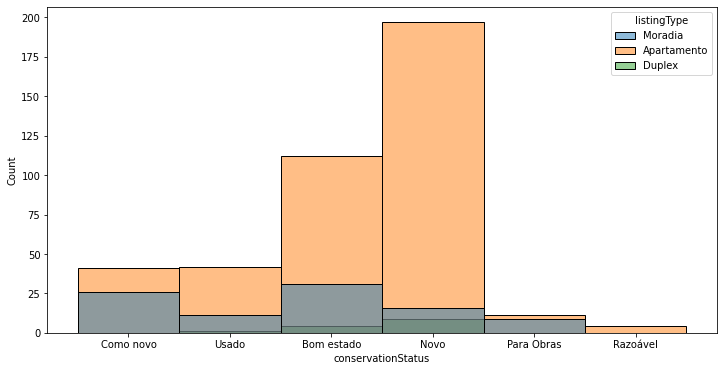

In [269]:
print(df_eda["conservationStatus"].value_counts())
plt.figure(figsize=(12,6))
sns.histplot(df_eda, x="conservationStatus", hue="listingType")
plt.show()

##### Energy Efficiency
 - Most houses lack an entry for the Energy Efficiency certificate.
 - This variable will need to be encoded later (during Data Transformation) for inclusion in our model.
 - G and F (the lowest ratings) are the least common.
 - A, C, and D are the most frequent ratings, which makes sense given that the market is dominated by new homes (typically high efficiency) or "mid-range" apartments in "good condition" (usually falling into the middle range, C and D).
 - A+, associated with exceptional quality or luxury, is understandably rare.

energyEfficiencyLevel
NC    115
C     113
A      98
D      92
E      39
B-     17
A+     17
B      12
F      10
G       1
Name: count, dtype: int64


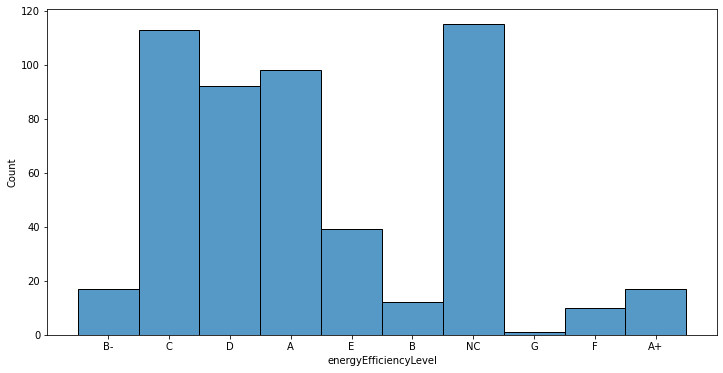

In [270]:
print(df_eda["energyEfficiencyLevel"].value_counts())
plt.figure(figsize=(12,6))
sns.histplot(df_eda, x="energyEfficiencyLevel")
plt.show()

#### Construction Year
 - We will examine the distribution and the top 10 most frequent construction years.
 - As seen with the conservation status, the most common years are current or future years, indicating new project homes.
 - Nearly 44% of houses have been, or are expected to be, built after 2020.
 - The average construction year is 2003, with a median of 2008.
 - Although our sample is small, it suggests a low construction rate between 2000 and 2020, which could be a result of the 2008 financial crisis.

In [271]:
total_entries = len(df_eda['constructionYear'])

entries_above_2020 = len(df_eda[df_eda['constructionYear'] > 2020])
percentage_above_2020 = (entries_above_2020 / total_entries) * 100

print(f"Percentage of entries with construction year above 2020: {percentage_above_2020:.2f}%")


Percentage of entries with construction year above 2020: 43.97%


constructionYear
2024    79
2023    41
2025    35
2028    31
2026    26
1988    13
2003    10
1985    10
1981    10
1982    10
Name: count, dtype: int64


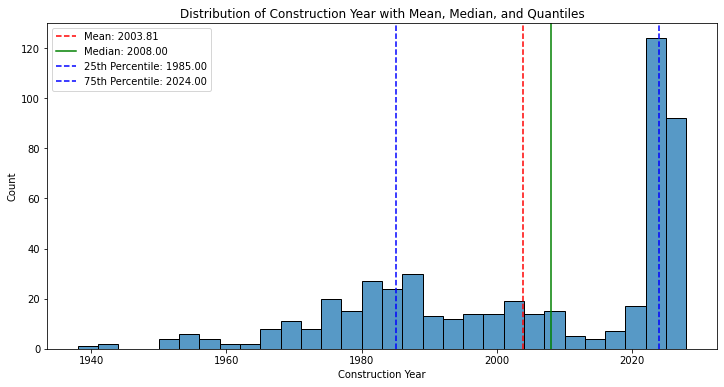

In [272]:
most_frequent_year = df_eda["constructionYear"].value_counts().iloc[0:10]
print(most_frequent_year)

mean_year = df_eda['constructionYear'].mean()
median_year = df_eda['constructionYear'].median()
quantiles = df_eda['constructionYear'].quantile([0.25, 0.75])


plt.figure(figsize=(12,6))
ax = sns.histplot(df_eda, x="constructionYear", bins=30, kde=False)

plt.axvline(mean_year, color='r', linestyle='--', label=f'Mean: {mean_year:.2f}')
plt.axvline(median_year, color='g', linestyle='-', label=f'Median: {median_year:.2f}')
plt.axvline(quantiles.iloc[0], color='b', linestyle='--', label=f'25th Percentile: {quantiles.iloc[0]:.2f}')
plt.axvline(quantiles.iloc[1], color='b', linestyle='--', label=f'75th Percentile: {quantiles.iloc[1]:.2f}')

plt.legend()
plt.title('Distribution of Construction Year with Mean, Median, and Quantiles')
plt.xlabel('Construction Year')
plt.ylabel('Count')
plt.show()

##### Location
 - Most houses are located in Algés.
 - As expected, regions with higher population density have more houses on the market.
 - Since this analysis is focused solely on Oeiras, we will exclude the region variable from our model.
 - Location is crucial for house prices, and in a future project, expanding to include more cities and fewer "freguesias" would enhance our price predictions.

localZone
Algés                    106
Carnaxide                 88
Oeiras                    76
Linda A Velha             59
Paço De Arcos             38
Barcarena                 36
Cruz Quebrada-Dafundo     27
Caxias                    25
Queijas                   25
Porto Salvo               21
Miraflores                 7
Queluz Baixo               1
carnaxide                  1
Nova Carnaxide             1
Dafundo                    1
Medrosa                    1
Leceia                     1
Name: count, dtype: int64


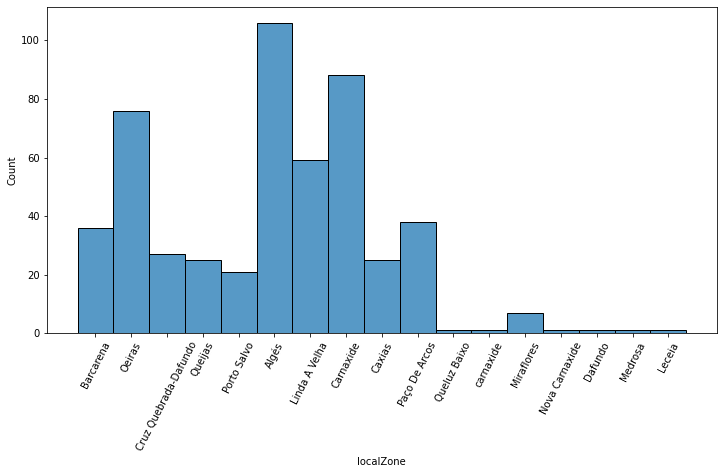

In [273]:
print(df_eda["localZone"].value_counts())
plt.figure(figsize=(12,6))
sns.histplot(df_eda, x="localZone")
plt.xticks(rotation=63)
plt.show()

#### Floor
 - The floor distribution is mostly concentrated on lower floors, which is expected since most buildings are not very tall, and even taller buildings have lower floors but not vice versa.
 - A key constraint to note is that "Moradias" are listed with floor = 0, which also corresponds to the lowest possible floor for apartments. However, the price impact is expected to differ between the two.
 - "Moradias" are not expected to be affected by floor level, while apartments on lower floors are likely to be cheaper.
 - We will need to create an interaction term to address this issue in our model.

floorAsNumber
0     166
2      70
1      65
3      59
10     41
4      39
5      23
8      15
6      13
7      12
9      11
Name: count, dtype: int64


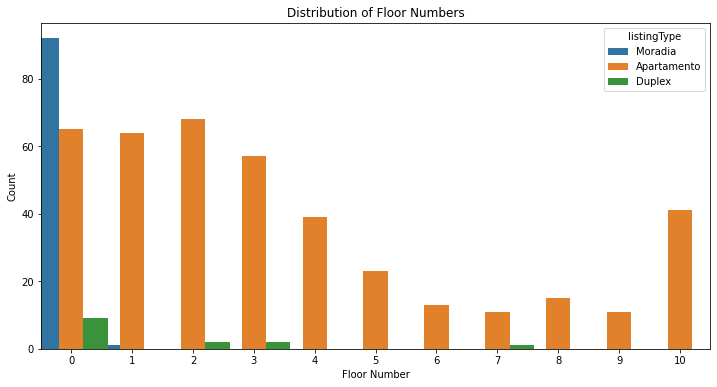

In [274]:
print(df_eda["floorAsNumber"].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(data=df_eda, x="floorAsNumber", order=sorted(df_eda['floorAsNumber'].unique()), hue="listingType", width=1.2)
plt.title('Distribution of Floor Numbers')
plt.xlabel('Floor Number')
plt.ylabel('Count')
plt.show()

#### Number Of Bedrooms

numberOfBedrooms
3     211
2     131
4      93
5      27
1      27
6       9
0       8
9       4
8       2
7       1
11      1
Name: count, dtype: int64


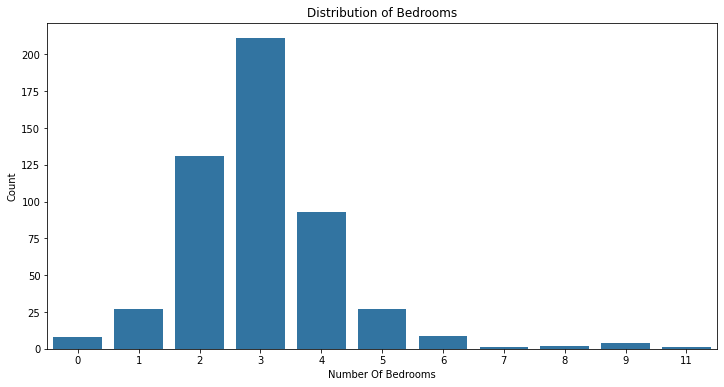

In [275]:
print(df_eda["numberOfBedrooms"].value_counts())

plt.figure(figsize=(12, 6))
sns.countplot(data=df_eda, x="numberOfBedrooms", order=sorted(df_eda['numberOfBedrooms'].unique()))
plt.title('Distribution of Bedrooms')
plt.xlabel('Number Of Bedrooms')
plt.ylabel('Count')
plt.show()

#### Listing Price
 - Price is right-skewed, so we need to log-transform this variable to reduce the skew and make the distribution more normal.
 - Heteroscedasticity will need to be examined later.
 - The mean significantly exceeds the median, which aligns with the right skew and tail of the distribution, driven by a few expensive houses raising the mean.

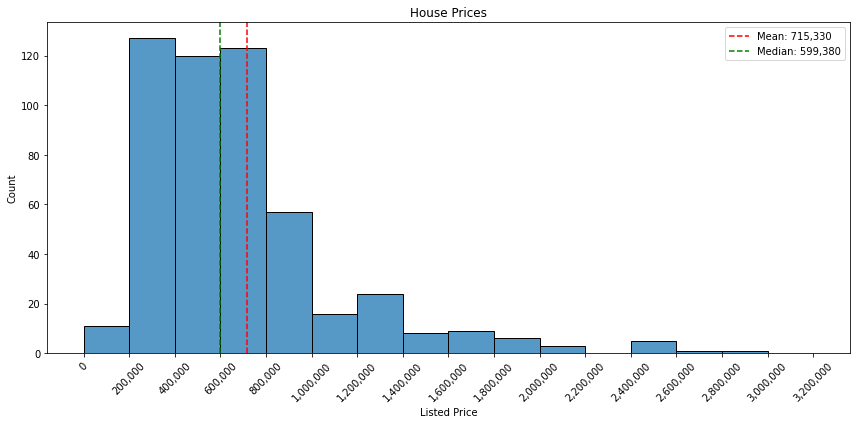

In [276]:
plt.figure(figsize=(12,6))

bins = range(0, 3400000, 200000)
sns.histplot(df_eda['listingPrice'], bins=bins)

listed_prices = np.array(df_eda['listingPrice'])
mean_price = np.mean(listed_prices)
median_price = np.median(listed_prices)

tick_values = list(bins)
tick_labels = [f'{x:,}' for x in tick_values]

plt.xticks(tick_values, tick_labels, rotation=45)
plt.xlabel('Listed Price')
plt.title('House Prices')
plt.axvline(mean_price, color='r', linestyle='--', label=f'Mean: {mean_price:,.0f}')
plt.axvline(median_price, color='g', linestyle='--', label=f'Median: {median_price:,.0f}')
plt.legend()
plt.tight_layout()
plt.show()

#### A second look at Correlation, Skewness and Distribution

In [277]:
num_columns = ["listingPrice", "constructionYear","garageSpots","floorAsNumber","elevator","numberOfBedrooms","numberOfBathrooms","totalArea","livingArea"]
df_eda[num_columns].corr()

,listingPrice,constructionYear,garageSpots,floorAsNumber,elevator,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea
listingPrice,1.000000,0.256632,0.574497,-0.012820,-0.048531,0.508054,0.699747,0.727823,0.769224
constructionYear,0.256632,1.000000,0.619226,0.271578,0.419457,-0.061412,0.355946,0.161382,0.152823
garageSpots,0.574497,0.619226,1.000000,0.189641,0.210452,0.324854,0.635836,0.506432,0.518290
floorAsNumber,-0.012820,0.271578,0.189641,1.000000,0.448960,-0.063680,0.145049,-0.044961,-0.018813
elevator,-0.048531,0.419457,0.210452,0.448960,1.000000,-0.181451,0.028987,-0.081236,-0.077624
numberOfBedrooms,0.508054,-0.061412,0.324854,-0.063680,-0.181451,1.000000,0.662732,0.686318,0.711874
numberOfBathrooms,0.699747,0.355946,0.635836,0.145049,0.028987,0.662732,1.000000,0.728323,0.746342
totalArea,0.727823,0.161382,0.506432,-0.044961,-0.081236,0.686318,0.728323,1.000000,0.906992
livingArea,0.769224,0.152823,0.518290,-0.018813,-0.077624,0.711874,0.746342,0.906992,1.000000


In [278]:
skewness = df_eda.select_dtypes(include='int64').skew()
print('Skewness of numerical features:\n', skewness)

Skewness of numerical features:
 listingPrice         4.215394
constructionYear    -0.583848
garageSpots         -0.137472
floorAsNumber        1.114551
numberOfBedrooms     1.446476
numberOfBathrooms    0.817144
totalArea            2.223275
livingArea           2.433405
Age                  0.584420
dtype: float64


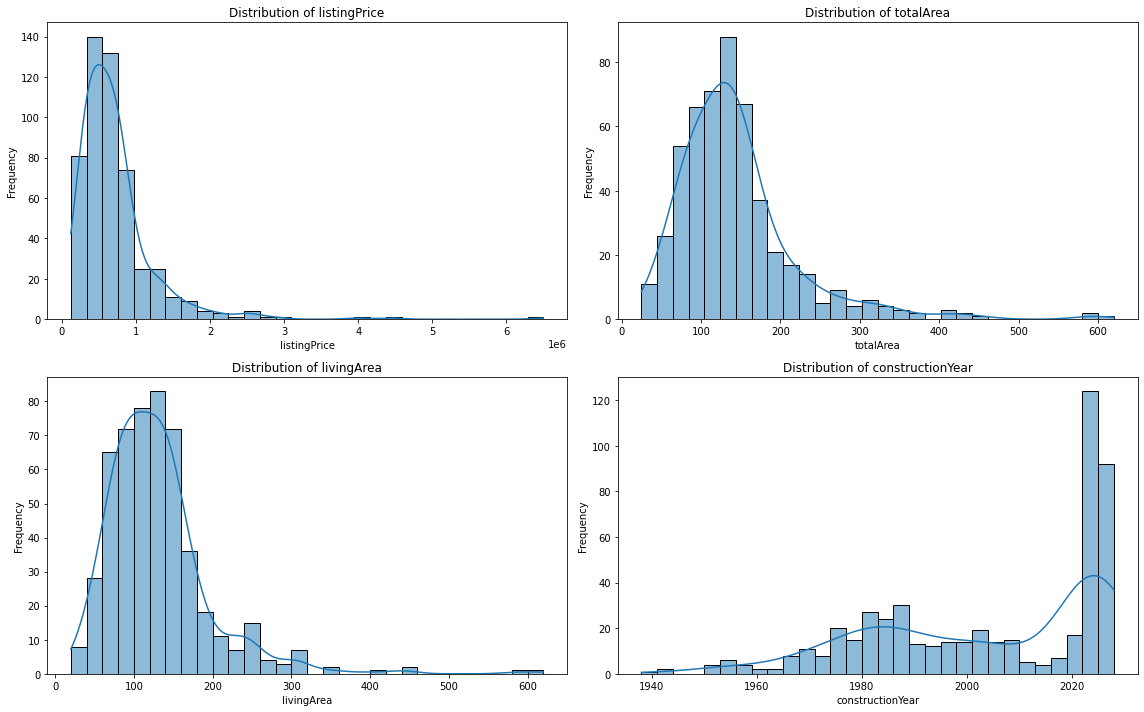

In [279]:
plt.figure(figsize=(16,10))
for i, column in enumerate(df_eda[["listingPrice","totalArea","livingArea","constructionYear"]].columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_eda[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 5) Data Transformation
 - Dropping unwanted columns for modelling
 - Normalizing skewed variables
 - Encoding

In [280]:
df_tr = df_eda.copy()
df_tr.columns

Index(['listingPrice', 'listingType', 'marketStatus', 'conservationStatus',
       'energyEfficiencyLevel', 'constructionYear', 'localZone', 'garage',
       'garageSpots', 'floorAsNumber', 'elevator', 'numberOfBedrooms',
       'numberOfBathrooms', 'totalArea', 'livingArea', 'Age'],
      dtype='object')

In [281]:
df_tr = df_tr.drop(columns=['localZone','garage','constructionYear','conservationStatus','marketStatus'])
df_tr['elevator'] = df_tr['elevator'].astype(int)

In [282]:
# Logging Continuous, Right Skewed variables

df_tr['log_totalArea'] = np.log(df_tr['totalArea'])
df_tr['log_livingArea'] = np.log(df_tr['livingArea'])
df_tr['log_listingPrice'] = np.log(df_tr['listingPrice'])

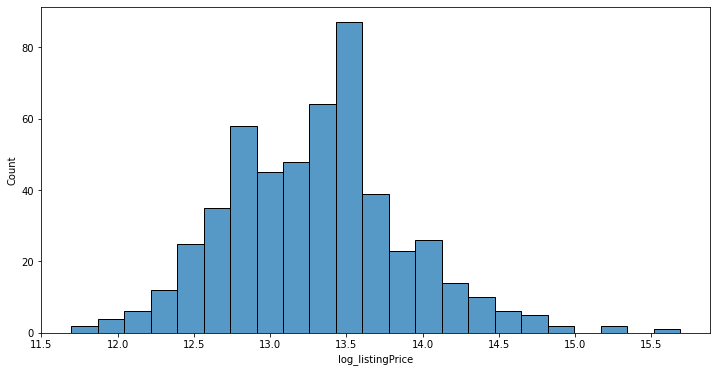

In [283]:
# Normalized Price Histogram

plt.figure(figsize=(12,6))
sns.histplot(df_tr, x="log_listingPrice")
plt.show()

In [284]:
# Energy Efficiency Encoding

# NC stays as NC
# F, G are "Very Bad"
# E, D are "OK"
# B-, B, C are "Good"
# A, A+ are "Very Good"

efficiency_mapping = {
    'NC': 'NC',
    'F': 'Very Bad',
    'G': 'Very Bad',
    'E': 'OK',
    'D': 'OK',               
    'B-': 'Good',
    'B': 'Good',
    'C': 'Good',
    'A': 'Very Good',
    'A+': 'Very Good'
}

df_tr['energyEfficiencyEncoded'] = df_tr['energyEfficiencyLevel'].map(efficiency_mapping)

In [285]:
df_encoded = pd.get_dummies(df_tr[['energyEfficiencyEncoded', 'listingType']], prefix=['energy', 'listing'])
df_tr = pd.concat([df_tr, df_encoded], axis=1)

In [286]:
# Turning Booleans to 0s and 1s
df_tr[['energy_Good', 'energy_NC',
       'energy_OK', 'energy_Very Bad', 'energy_Very Good',
       'listing_Apartamento', 'listing_Duplex', 'listing_Moradia']] = df_tr[['energy_Good', 'energy_NC',
       'energy_OK', 'energy_Very Bad', 'energy_Very Good',
       'listing_Apartamento', 'listing_Duplex', 'listing_Moradia']].astype(int)

In [287]:
df_tr.head()

,listingPrice,listingType,energyEfficiencyLevel,garageSpots,floorAsNumber,elevator,numberOfBedrooms,numberOfBathrooms,totalArea,livingArea,...,log_listingPrice,energyEfficiencyEncoded,energy_Good,energy_NC,energy_OK,energy_Very Bad,energy_Very Good,listing_Apartamento,listing_Duplex,listing_Moradia
2,2595000,Moradia,B-,2,0,0,5,6,440,440,...,14.769097,Good,1,0,0,0,0,0,0,1
5,1000000,Apartamento,C,1,3,1,4,3,155,155,...,13.815511,Good,1,0,0,0,0,1,0,0
6,299000,Apartamento,D,0,0,0,2,1,59,58,...,12.608199,OK,0,0,1,0,0,1,0,0
7,690000,Moradia,D,1,0,0,6,4,302,302,...,13.444447,OK,0,0,1,0,0,0,0,1
8,784100,Apartamento,A,2,3,0,2,2,123,123,...,13.572292,Very Good,0,0,0,0,1,1,0,0


## 6) Linear Regression Modelling
 - Multicolinearity Analysis and Testing
 - VIF Analysis

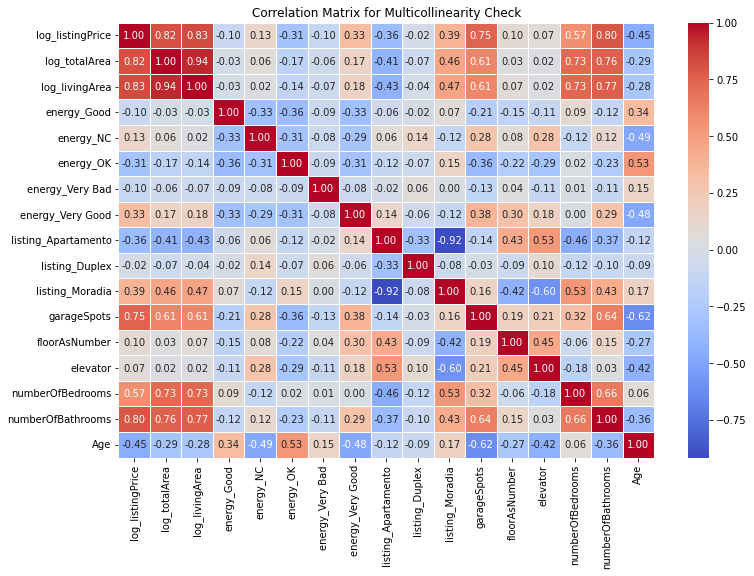

In [289]:
df_reg_test = df_tr[['log_listingPrice','log_totalArea','log_livingArea','energy_Good', 'energy_NC',
       'energy_OK', 'energy_Very Bad', 'energy_Very Good',
       'listing_Apartamento', 'listing_Duplex', 'listing_Moradia','garageSpots',
       'floorAsNumber', 'elevator', 'numberOfBedrooms', 'numberOfBathrooms','Age']]

correlation_matrix = df_reg_test.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Multicollinearity Check")
plt.show()

#### Retesting
 - Removing Dummy variables to avoid Dummy Variable Trap (Perfect Multicollinearity)
 - Removing Total Area and Bathrooms which are highly correlated

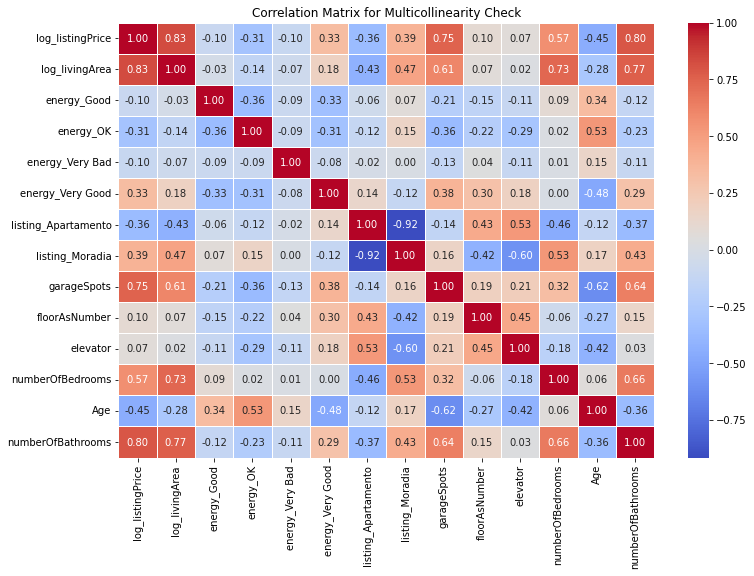

In [290]:
df_reg_test2 = df_reg_test[['log_listingPrice', 'log_livingArea', 'energy_Good', 'energy_OK',
       'energy_Very Bad', 'energy_Very Good', 'listing_Apartamento',
       'listing_Moradia', 'garageSpots', 'floorAsNumber', 'elevator',
       'numberOfBedrooms', 'Age','numberOfBathrooms']]

correlation_matrix = df_reg_test2.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Multicollinearity Check")
plt.show()

#### Retesting 2.0
 - Creating an interaction term as Area and Bedrooms are too correlated

 - Given "FloorAsNumber" is not expected to be normally distributed, and given it is not expected to have a linear effect on the house price, (R/C apartments vs Moradias) we will create an interaction term between Floor and Listing Type. This term will only capture the floor effect for apartments, as it will be zero for houses (Moradias)

In [291]:
df_reg_test2['area_bedrooms_bathrooms_interaction'] = df_reg_test2['log_livingArea'] * df_reg_test2['numberOfBedrooms'] * df_reg_test2['numberOfBathrooms']
df_reg_test2['floor_apartment_interaction'] = df_reg_test2['floorAsNumber'] * df_reg_test2['listing_Apartamento']

/tmp/ipykernel_616/1711102569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg_test2['area_bedrooms_bathrooms_interaction'] = df_reg_test2['log_livingArea'] * df_reg_test2['numberOfBedrooms'] * df_reg_test2['numberOfBathrooms']
/tmp/ipykernel_616/1711102569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg_test2['floor_apartment_interaction'] = df_reg_test2['floorAsNumber'] * df_reg_test2['listing_Apartamento']


In [292]:
df_reg_test2.columns

Index(['log_listingPrice', 'log_livingArea', 'energy_Good', 'energy_OK',
       'energy_Very Bad', 'energy_Very Good', 'listing_Apartamento',
       'listing_Moradia', 'garageSpots', 'floorAsNumber', 'elevator',
       'numberOfBedrooms', 'Age', 'numberOfBathrooms',
       'area_bedrooms_bathrooms_interaction', 'floor_apartment_interaction'],
      dtype='object')

In [293]:
df_reg_test3 = df_reg_test2[['log_listingPrice', 'energy_Good', 'energy_OK',
       'energy_Very Bad', 'energy_Very Good',
       'listing_Moradia', 'garageSpots', 'elevator',
       'Age','floor_apartment_interaction','log_livingArea']]

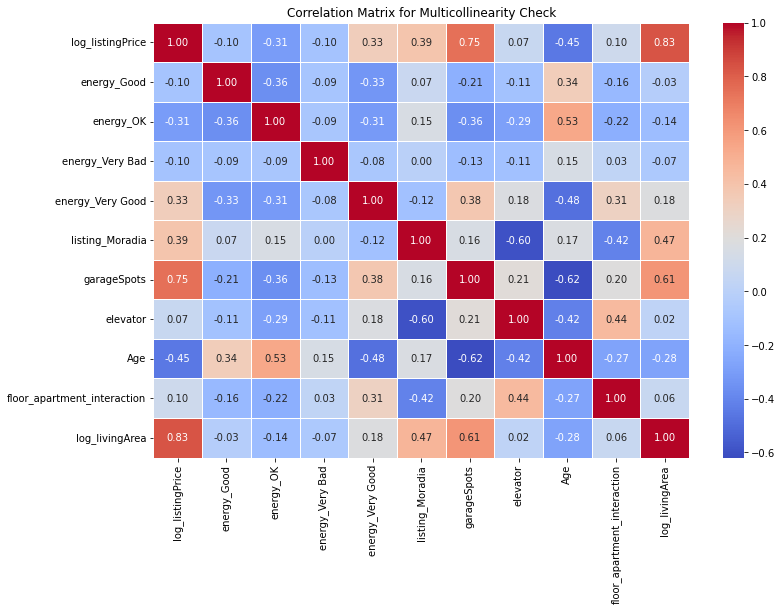

In [294]:
correlation_matrix = df_reg_test3.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Multicollinearity Check")
plt.show()

#### Final Correlation Check

In [295]:
df_reg_test3.columns

Index(['log_listingPrice', 'energy_Good', 'energy_OK', 'energy_Very Bad',
       'energy_Very Good', 'listing_Moradia', 'garageSpots', 'elevator', 'Age',
       'floor_apartment_interaction', 'log_livingArea'],
      dtype='object')

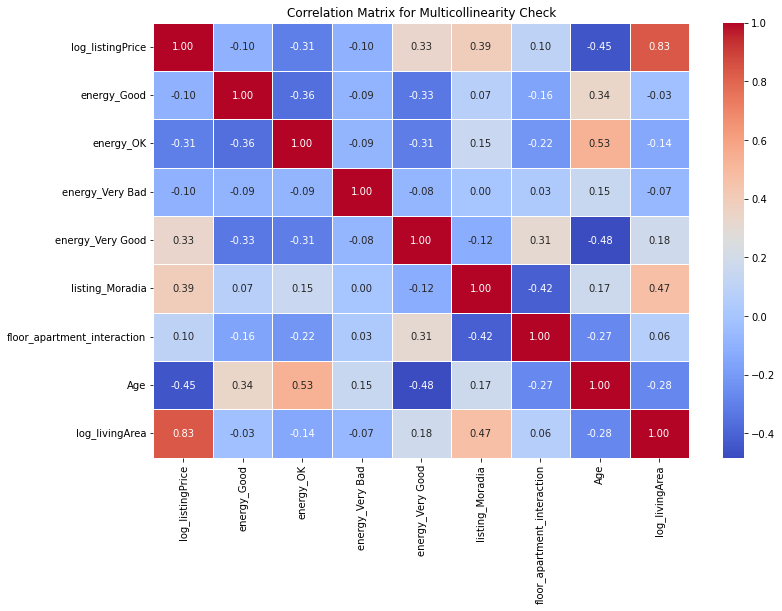

In [296]:
final_df = df_reg_test3[['log_listingPrice','energy_Good', 'energy_OK', 'energy_Very Bad',
       'energy_Very Good', 'listing_Moradia',
       'floor_apartment_interaction', 'Age',
       'log_livingArea']]

correlation_matrix = final_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Multicollinearity Check")
plt.show()

#### Linear Regression Model and Plot

In [297]:
feature_columns = ['energy_Good', 'energy_OK', 'energy_Very Bad',
       'energy_Very Good', 'listing_Moradia','floor_apartment_interaction',
       'Age','log_livingArea']
target_variable = 'log_listingPrice'

X = df_reg_test3[feature_columns]
y = df_reg_test3[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.1097276768566914
R-squared: 0.7311024885109989


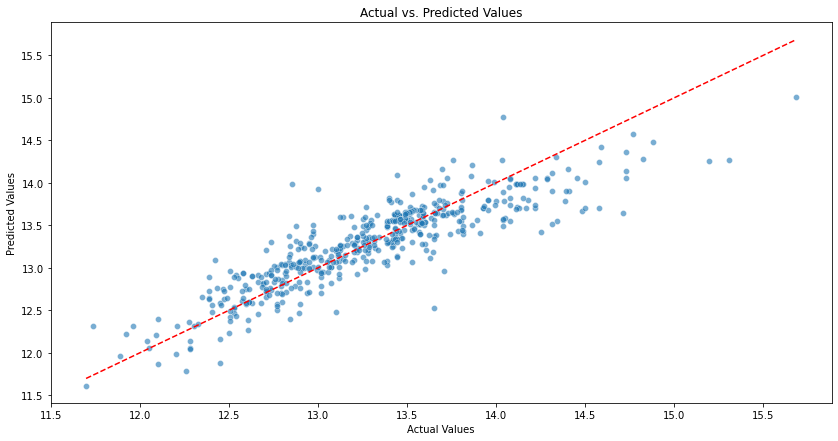

In [298]:
y_pred = model.predict(X)

plt.figure(figsize=(14, 7))
sns.scatterplot(x=y, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

##### Model Summary (Using Stats Model) and VIF Analysis

In [299]:
# Adding a constant (for the intercept)
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r_squared}')

                            OLS Regression Results                            
Dep. Variable:       log_listingPrice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     216.1
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.12e-157
Time:                        01:26:59   Log-Likelihood:                -69.517
No. Observations:                 514   AIC:                             157.0
Df Residuals:                     505   BIC:                             195.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [300]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)

                       Feature       VIF
0                  energy_Good  3.965787
1                    energy_OK  4.902053
2              energy_Very Bad  1.319088
3             energy_Very Good  2.056553
4              listing_Moradia  1.620711
5  floor_apartment_interaction  2.607935
6                          Age  5.532457
7               log_livingArea  6.498645


In [204]:
output_file = 'Final_Model_Summary.txt'
with open(output_file, 'w') as f:
    with contextlib.redirect_stdout(f):
        print(summary)